# Fresh take

## 1. Initalize sites

In [11]:
%load_ext autoreload
import os
import os
import shutil
import dbPipeline
import time


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
%autoreload 2

projectPath = os.path.join(os.getcwd(),'test2')

try:
    shutil.rmtree(projectPath)
except:
    pass

db = dbPipeline.database(projectPath=projectPath)
# db.projectInventory()
Sites = r'example_data\projectInventory_Template.yml'
db.projectInventory(newSites=Sites)


In [13]:
from parseFiles.helperFunctions.loadDict import loadDict
# importlib.reload(dbPipeline)

# db = dbPipeline.database(projectPath=projectPath,verbose=False,enableParallel=False)
template = loadDict(r'example_data\source_Template.yml')
# # sourcePath = r'U:\EC_Backup\SCL_2024\20240724'
sourcePath = r'example_data'
for siteID in template:
    for measurementID in template[siteID]:
        db.rawFileSearch(siteID,measurementID,sourcePath=sourcePath,**template[siteID][measurementID])

                     Lat           Lon            Zm    Zm_adj_Avg  LI7700_u  \
TIMESTAMP                                                                      
2024-08-19  6.922642e+01  1.352519e+02  3.285000e+00  3.225708e+00     0.230   
2024-08-20  4.202102e+06  2.356564e-41 -3.758524e+20 -7.393419e+19     0.000   
2024-08-21  4.414000e+00 -1.737500e-01  2.223001e+01  5.300000e+01     3.890   
2024-08-22 -2.124258e+20 -2.066687e+20  5.673254e+08 -3.341687e-19    69.210   
2024-08-23  2.720654e+01 -3.689349e+19  2.298023e+01  0.000000e+00     3.520   
2024-08-24  2.350398e-41  7.667264e+34 -2.713126e+19 -5.438501e+22     0.000   
2024-08-25  4.291300e+01 -4.542750e+00  3.764500e+00  8.000000e-03     4.330   
2024-08-26 -8.056948e+24 -2.212485e+24 -2.092219e+30  6.825743e+33  6891.000   
2024-08-27  2.490000e+02  5.625000e+01  2.720654e+01 -3.689349e+19     4.480   
2024-08-28  1.625482e-15  2.537838e+15  2.350398e-41  2.203338e+33     7.416   
2024-08-29  2.126890e+01  1.018210e+02  

c:\Users\jskeeter\gsc-permafrost\EC_dataPipeline\test2\database\SCL\WSM_Profile\2024\POSIX_timestamp
c:\Users\jskeeter\gsc-permafrost\EC_dataPipeline\dbPipeline.py line 208:
?

c:\Users\jskeeter\gsc-permafrost\EC_dataPipeline\dbPipeline.py line 229:
c:\Users\jskeeter\gsc-permafrost\EC_dataPipeline\test2\database\SCL\WSM_Profile\2024\_variableMap.yml



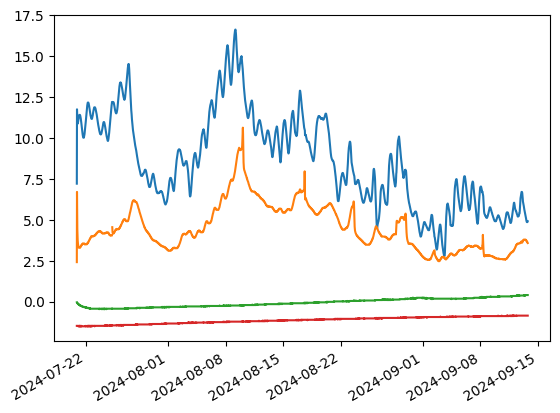

In [168]:
import numpy as np
import matplotlib.pyplot as plt
importlib.reload(dbPipeline)
path = projectPath + r'\database\SCL\Met'
path = projectPath + r'\database\SCL\WSM_Profile'
f = dbPipeline.databaseFolder(path = path,Years= 2024)
fig = plt.figure()
Data = f.dataOut
# Data.loc[((Data['AirTC_Avg']>50)|(Data['AirTC_Avg']<-60)),'AirTC_Avg']=np.nan
# plt.plot(Data['AirTC_Avg'])
plt.plot(Data['TS_1_2_1'])
plt.plot(Data['TS_2_2_1'])
plt.plot(Data['TS_3_2_1'])
plt.plot(Data['TS_4_2_1'])
fig.autofmt_xdate()

In [57]:
import matplotlib.pyplot as plt
import rawDataFile
import importlib
importlib.reload(rawDataFile)
rd = rawDataFile.TOB3(sourceFile=r'u:\EC_Backup\SCL_2024\20240912\Flux_Data495.dat')
# rd.Data['Diagnostic_CSAT']=0
rd.Data.to_csv('SCL_Data_'+rd.fileTimestamp+'.dat',index=False)
# 'Flux_Data_'+rd.fileTimestamp+'.dat'
# rd.fileTimestamp
# rd.Data.to_csv('Test.dat')
# plt.figure()
# plt.plot(rd.Data['Diagnostic_CSAT'][:-1])
rd.Data.shape


c:\Users\jskeeter\gsc-permafrost\EC_dataPipeline\rawDataFile.py line 216:
Frames 3000



(36000, 18)

In [ ]:
import configparser

ini = configparser.ConfigParser()
ini.read(r'config_files/GHG_md_template.metadata')
for s in ini.sections():
    if s != 'Files':
        for key,value in (ini[s].items()):
            ini[s][key] = ''
ini

with open(r'config_files/GHG_ep_template.metadata', 'w') as f:
    f.write(';GHG_METADATA\n')
    ini.write(f,space_around_delimiters=False)